# Test model with NDS

In [1]:
import sys
sys.path.append("..")
sys.path.append("../../")
import numpy as np
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt

from model_settings import img_height, img_width, min_blobs_test, max_blobs_test, max_blobs_train, min_blobs_train

In [19]:
margin = 5
spacing = 20
width = height = 3
min_blobs = min_blobs_test # 1
max_blobs = max_blobs_test # 9
output_size = 1
num_labels = max_blobs - min_blobs + 1 # 10
num_sequences = 1000
num_runs = 10

In [3]:
NDS_data = np.load("/home/mtfang/increments_copy/NDS_data.npy")
NDS_data = NDS_data.item()
images = NDS_data["images"] # size: (1000,10,10000)
label_saclar = NDS_data["label_scalar"] 

# Test NDS with checkpoints

- use original model of swap tests (PDP Note 6/9/20)
- check /home/mtfang/DRAM/Visualization/Estimation/ClassifyHiddenUnits.ipynb
- swap test code: /home/mtfang/DRAM/FF_estimation_classifier(scalar)_swap.py


In [60]:
# parameters
read_n = 15  # N x N filterbank for each layer
dims = [img_height,img_width] # input_img size
eps = 1e-8 # epsilon for numerical stability
delta_1=max(dims[0],dims[1])/(read_n-1) 
sigma2_1=delta_1*delta_1/4 # sigma=delta/2 
batch_size = 1
iter_num = 3000000
MODELNAME = ['CAA_const_fN', 'CAA_decrs_fN', 'DAA_const_fN', 'DAA_decrs_fN']
MODE = MODELNAME[3]

In [61]:
def filterbank(gx, gy, N):
    grid_i = np.reshape(np.arange(N), [1, -1])
    mu_x_1 = gx + (grid_i - N / 2 + 0.5) * delta_1 # eq 19 batch_size x N
    mu_y_1 = gy + (grid_i - N / 2 + 0.5) * delta_1 # eq 20 batch_size x N
    a = np.reshape(np.arange(dims[0]), [1, 1, -1]) # 1 x 1 x dims[0]
    b = np.reshape(np.arange(dims[1]), [1, 1, -1]) # 1 x 1 x dims[1]

    mu_x_1 = np.reshape(mu_x_1, [-1, N, 1]) # batch_size x N x 1
    mu_y_1 = np.reshape(mu_y_1, [-1, N, 1])
    Fx_1 = np.exp(-np.square(a - mu_x_1) / (2*sigma2_1)) # batch_size x N x dims[0]
    Fy_1 = np.exp(-np.square(b - mu_y_1) / (2*sigma2_1)) # batch_size x N x dims[1]
    # normalize, sum over A and B dims
    Fx_1=Fx_1/np.maximum(np.sum(Fx_1,2,keepdims=True),eps)
    Fy_1=Fy_1/np.maximum(np.sum(Fy_1,2,keepdims=True),eps)
    return Fx_1, Fy_1, mu_x_1, mu_y_1

def attn_window(scope, N):  
    gx=dims[0]/2  
    gy=dims[1]/2 
    gx=np.reshape([gx]*batch_size, [batch_size,1])
    gy=np.reshape([gy]*batch_size, [batch_size,1])
    Fx_1, Fy_1, mu_x_1, mu_y_1 = filterbank(gx, gy, N)
    return Fx_1, Fy_1, gx, gy


def read(x):
    Fx_1, Fy_1, gx, gy = attn_window("read", read_n)
    stats = Fx_1, Fy_1
    new_stats = gx, gy
    
    def filter_img(img, Fx_1, Fy_1, N):
        Fxt_1 = np.transpose(Fx_1, axes=[0,2,1])
        # img: 1 x img_size
        img = np.reshape(img,[-1, dims[1], dims[0]])
        fimg_1 = np.matmul(Fy_1, np.matmul(img, Fxt_1))
        fimg_1 = np.reshape(fimg_1,[-1, N*N])
        # normalization (if do norm, Pc will be nan)
        # scalar_1 = tf.reshape(tf.reduce_max(fimg_1, 1), [batch_size, 1])
        # fimg_1 = fimg_1/tf.reduce_max(fimg_1, 1, keepdims=True)
        fimg = fimg_1 
        return fimg

    xr = filter_img(x, Fx_1, Fy_1, read_n) # batch_size x (read_n*read_n)
    return xr, new_stats # concat along feature axis

def linear(x, w, b):
    output = np.matmul(x, w) + b
    return output

def hidden_activation(x, w, b):
    xr, _ = read(x)
    hidden = np.maximum(0, linear(xr, w, b))
    return hidden

def classifier(h, w, b):
    classification = linear(hidden, w, b)
    return classification

In [62]:
estimate = np.zeros([num_runs, num_sequences, num_labels+1]) # estimate of NDS: e(n,s)
difference = np.zeros([num_runs, num_sequences, num_labels]) # differences between consecutive d(n,s)=e(n,s)-e(n-1,s)

print("MODE(scalar):", MODE)
for run_idx in range(num_runs):
    test_run = run_idx + 1
    print("run:", test_run)
    ckpt_file = "/home/mtfang/DRAM/model_runs/estimation/scalar_model/scalar_"+MODE+"_run"+str(test_run)+"/classifymodel_"+str(iter_num)+".ckpt"
    # load pre-trained model
    ckpt_reader = tf.train.load_checkpoint(ckpt_file)
    hidden_w = ckpt_reader.get_tensor("hidden/w") # size(225,250)
    hidden_b = ckpt_reader.get_tensor("hidden/b") # size(250,)
    output_w = ckpt_reader.get_tensor("output/w") # size(250,15)
    output_b = ckpt_reader.get_tensor("output/b") # size(15,)
    for s_idx in range(num_sequences): 
        for n_idx in range(num_labels+1):
            x = images[s_idx][n_idx]
            hidden = hidden_activation(x, hidden_w, hidden_b)
            classification = classifier(hidden, output_w, output_b)
            estimate[run_idx][s_idx][n_idx] = classification
            if n_idx != 0:
                difference[run_idx][s_idx][n_idx-1] = estimate[run_idx][s_idx][n_idx]-estimate[run_idx][s_idx][n_idx-1]
print("Done!")

MODE(classifier): DAA_decrs_fN
run: 1
run: 2
run: 3
run: 4
run: 5
run: 6
run: 7
run: 8
run: 9
run: 10
Done!


In [63]:
np.save("/home/mtfang/increments_copy/data_NDS/FF_scalar_data/FF_scalar_"+MODE+"_estimate.npy", estimate)
np.save("/home/mtfang/increments_copy/data_NDS/FF_scalar_data/FF_scalar_"+MODE+"_difference.npy", difference)

In [64]:
# the mean md(n) and standard deviation sdd(n) of d(n,s) over a population of sequences s
md_n = np.mean(difference, axis=1) 
sdd_n = np.std(difference, axis=1, ddof=1)
# c(n,n-1): the correlation of the variability in the n'th difference with the preceding difference
c_n = np.zeros([num_runs, num_labels-1])
for run_idx in range(num_runs):
    for n_idx in range(1, num_labels):
        d_n = difference[run_idx,:,n_idx]
        m_n = md_n[run_idx][n_idx]
        sd_n = sdd_n[run_idx][n_idx]
        
        d_n_1 = difference[run_idx,:,n_idx-1]
        m_n_1 = md_n[run_idx][n_idx-1]
        sd_n_1 = sdd_n[run_idx][n_idx-1]
        
        #c_n[run_idx][n_idx-1] = np.mean((d_n-m_n)*(d_n_1-m_n_1))/(sd_n*sd_n_1)
        c_n[run_idx][n_idx-1] = np.corrcoef(difference[run_idx,:,n_idx], difference[run_idx,:,n_idx-1])[0,1]

# Curve Fitting

In [65]:
import math
import scipy.stats as st
import scipy.optimize as opt


def powfit(x, slope, power):
    y = slope * np.power(x, power) 
    return y


def get_powreg(cvals, eouts=range(2,10)):
    """Get power curve of best fit, comparing expected number of blobs to actual number of blobs output."""
    
    slopes = np.zeros(num_runs)
    powers = np.zeros(num_runs)
    
    for run in range(num_runs):
        aouts = np.array([cvals[run,eout-min_blobs-1] for eout in eouts])
        popt, pcov = opt.curve_fit(powfit, eouts, aouts, [1,1], maxfev=2000)
        slopes[run], powers[run] = popt

    return slopes, powers

def get_CI(vals):
    """Get the 95% confidence intervals."""
    n = len(vals)
    mean = np.mean(vals)
    sd = np.std(vals)
    hw = 1.96*sd/math.sqrt(n)
#     print("CI: (" + str(mean - hw) + ", " + str(mean + hw) + ")")
    return round(mean, 4), round(hw, 4)

In [66]:
def plot_stats_mu(cval): 
    
    cval_subset = cval[:,1:9] # N=1-9
    
    smu = np.mean(cval_subset,axis=0)
    smin = np.min(cval_subset,axis=0)
    smax = np.max(cval_subset,axis=0)
    
    #fig, ax = plt.subplots(1,1)
    fig, ax = plt.subplots(1, 1, figsize=(6,8))
    x = [2,3,4,5,6,7,8,9]

    tstr = 'Iter = ' + str(iter_num)
    ax.set_title(tstr)
    ax.plot(x,smu,'k-')
    ax.fill_between(x,smin,smax, facecolor='orange')
        
    ax.set_xlim(1, 10)
    ax.set_ylim(0, 3)
    ax.set_xticks(x)
    #ax.set_yticks(x)
    ax.set_xlabel('n', fontsize=15)
        
    b, c = get_powreg(cval_subset)
    b_mean, b_hw = get_CI(b)
    c_mean, c_hw = get_CI(c)
            
    #for j in range(num_runs):
    #    print("run:%d, b=%.3f, c=%.3f" % (j+1,b[j],c[j]))
        
    ax.text(0.75, .6, 'Curve Fitting:\n' + \
            '$b: ' + str(b_mean) + ' \pm ' + str(b_hw) + \
            '$ \n $c: ' + str(c_mean) + ' \pm ' + str(c_hw) + '$',
            horizontalalignment='center',
            verticalalignment='bottom',
            transform=ax.transAxes)

    popt = [b_mean,c_mean]
    ax.plot(x, powfit(x, *popt), 'r--',label='fit: b=%5.3f, c=%5.3f' % tuple(popt))
        
    ax.set_aspect('equal', 'box')
    ax.grid(True)

plt.show()

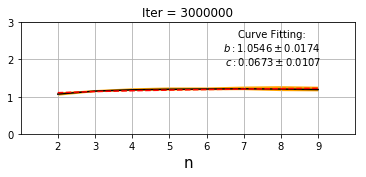

In [67]:
plot_stats_mu(md_n)

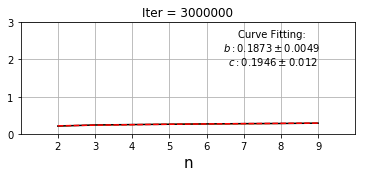

In [58]:
plot_stats_mu(sdd_n)

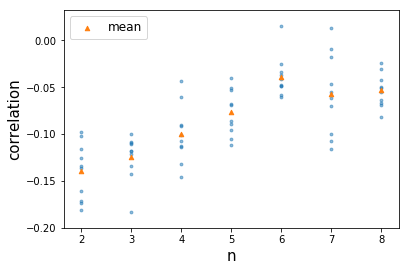

In [59]:
x_c = [2,3,4,5,6,7,8]
plt.scatter(x_c*num_runs, np.reshape(c_n[:,1:8], [1,-1]), s=8, alpha=0.5)
plt.scatter(x_c, np.mean(c_n[:,1:8],0), s=20, marker='^', label="mean")
plt.legend(loc='upper left', fontsize=12)
plt.xlabel("n", fontsize=15)
plt.ylabel("correlation", fontsize=15)